## 📍 **데이터 확인**

### **Fixed Random Seed**
seed 값에 의해 동일한 코드를 사용해도 결과가 다를 수 있기에, 동일한 결과를 위해 seed 값을 고정시킵니다

In [1]:
import os
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

### **데이터 불러오기 및 상위행 확인**
train.csv, test.csv 파일을 로드하여 상위행을 출력해 봅시다

In [2]:
import pandas as pd 

train_org = pd.read_csv('./data/train.csv') 
test_org = pd.read_csv('./data/test.csv')

display(train_org.head())
display(test_org.tail())

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차
10962,ACCIDENT_50571,2022-12-31 21,토요일,맑음,대구광역시 동구 효목동,교차로 - 교차로부근,건조,차대차


### **train, test 데이터 기간 확인하기**
학습(train) 데이터의 기간과 예측 대상이 되는 test 데이터의 기간을 살펴 봅니다

In [3]:
display(f"train : {train_org.iloc[0]['사고일시']} ~ {train_org.iloc[-1]['사고일시']}")
display(f"test : {test_org.iloc[0]['사고일시']} ~ {test_org.iloc[-1]['사고일시']}")     

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

### **예측 대상 확인하기**
sample_submission.csv를 로드하여 출력 형식을 확인해 봄으로서, 대회 페이지 규칙에 기술되어 있는, 예측 대상이 무엇인지 확인해 봅시다.

최종적으로 예측해야 하는 값은 'ECLO'(인명피해 심각도) 값입니다.

그러나, train데이터 컬럼에 있는 '사망자수', '중상자수', '경상자수', '부상자수'를 각각 예측하여 ECLO 예측값을 구할 수도 있습니다. 즉, ECLO 값을 예측하는 단일 모델로 접근할 수도, 각각을 별도로 예측하는 모델로 접근할 수도 있습니다.

In [4]:
sample_submission = pd.read_csv("./data/sample_submission.csv")
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0


## 📍 **데이터 전처리**

### **파생 변수 생성 1 : 날짜, 시간정보 생성**
'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [5]:
train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})' 

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다 
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다 

# 해당 과정을 test_x에 대해서도 반복해줍니다 
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

In [6]:
train_df.head()

,ID,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간
0,ACCIDENT_00000,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,중상,0,1,0,0,5,2019,1,1,0
1,ACCIDENT_00001,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,...,경상,0,0,1,0,3,2019,1,1,0
2,ACCIDENT_00002,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,경상,0,0,1,0,3,2019,1,1,1
3,ACCIDENT_00003,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,중상,0,1,0,0,5,2019,1,1,2
4,ACCIDENT_00004,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,경상,0,0,1,0,3,2019,1,1,4


In [7]:
test_df.head()

,ID,요일,기상상태,시군구,도로형태,노면상태,사고유형,연,월,일,시간
0,ACCIDENT_39609,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,2022,1,1,1
1,ACCIDENT_39610,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,2022,1,1,1
2,ACCIDENT_39611,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차,2022,1,1,4
3,ACCIDENT_39612,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차,2022,1,1,4
4,ACCIDENT_39613,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차,2022,1,1,6


### **파생 변수 생성 2 : 공간(위치) 정보 생성**
'시군구' 컬럼으로부터 의미 있는 공간 정보를 추출 및 변환 합니다

In [8]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간', '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

In [9]:
train_df.head()

,ID,요일,기상상태,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,...,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동
0,ACCIDENT_00000,화요일,맑음,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,...,0,0,5,2019,1,1,0,대구광역시,중구,대신동
1,ACCIDENT_00001,화요일,흐림,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,...,1,0,3,2019,1,1,0,대구광역시,달서구,감삼동
2,ACCIDENT_00002,화요일,맑음,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,...,1,0,3,2019,1,1,1,대구광역시,수성구,두산동
3,ACCIDENT_00003,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,...,0,0,5,2019,1,1,2,대구광역시,북구,복현동
4,ACCIDENT_00004,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,...,1,0,3,2019,1,1,4,대구광역시,동구,신암동


In [10]:
test_df.head()

,ID,요일,기상상태,도로형태,노면상태,사고유형,연,월,일,시간,도시,구,동
0,ACCIDENT_39609,토요일,맑음,교차로 - 교차로안,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동
1,ACCIDENT_39610,토요일,맑음,단일로 - 기타,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동
2,ACCIDENT_39611,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가
3,ACCIDENT_39612,토요일,맑음,단일로 - 기타,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동
4,ACCIDENT_39613,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동


In [11]:
set(test_df['동'])

{'가창면',
 '가천동',
 '각산동',
 '갈산동',
 '감삼동',
 '검단동',
 '검사동',
 '계산동1가',
 '계산동2가',
 '고모동',
 '고성동1가',
 '고성동2가',
 '고성동3가',
 '공평동',
 '관음동',
 '괴전동',
 '교동',
 '구암동',
 '구지면',
 '국우동',
 '금강동',
 '금호동',
 '남산동',
 '남성로',
 '남일동',
 '내당동',
 '노곡동',
 '노변동',
 '노원동1가',
 '노원동2가',
 '노원동3가',
 '논공읍',
 '능성동',
 '다사읍',
 '달성동',
 '대곡동',
 '대림동',
 '대명동',
 '대봉동',
 '대신동',
 '대안동',
 '대천동',
 '대현동',
 '대흥동',
 '덕곡동',
 '덕산동',
 '도동',
 '도원동',
 '도학동',
 '동내동',
 '동문동',
 '동변동',
 '동산동',
 '동성로1가',
 '동성로2가',
 '동성로3가',
 '동인동1가',
 '동인동2가',
 '동인동3가',
 '동인동4가',
 '동일동',
 '동천동',
 '동호동',
 '두류동',
 '두산동',
 '만촌동',
 '매여동',
 '매천동',
 '매호동',
 '문화동',
 '미곡동',
 '미대동',
 '방촌동',
 '백안동',
 '범물동',
 '범어동',
 '복현동',
 '본동',
 '본리동',
 '봉덕동',
 '봉무동',
 '봉산동',
 '부동',
 '북성로1가',
 '북성로2가',
 '불로동',
 '비산동',
 '사복동',
 '사수동',
 '사월동',
 '사일동',
 '산격동',
 '삼덕동',
 '삼덕동1가',
 '삼덕동2가',
 '삼덕동3가',
 '상동',
 '상리동',
 '상매동',
 '상서동',
 '상인동',
 '서문로1가',
 '서문로2가',
 '서변동',
 '서성로1가',
 '서성로2가',
 '서호동',
 '성당동',
 '성동',
 '송정동',
 '송현동',
 '수동',
 '수성동1가',
 '수성동2가',
 '수성동3가',
 '수성동4가',
 '수창동',
 '숙천동',
 '시장북로'

### **파생 변수 추출 3 : 도로 형태 정보 추출**
'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [12]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

In [13]:
train_df.head()

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,...,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,...,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,...,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,...,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,...,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타


In [14]:
test_df.head()

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안


### **전처리 결과 확인**

In [15]:
display(train_df.head())
display(test_df.head())

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,...,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,...,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,...,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,...,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,...,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,...,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안


## 📍 **탐색적 데이터 분석**
다양한 통계적 분석 및 시각화를 통해 타겟 변수인 ECLO(인명피해 심각도)에 영향을 미치는 피처(feature)가 무엇인지 관찰해 봅시다. 또한 이러한 과정에서, 타겟변수에 대한 설명력을 높이는 파생 변수를 어떻게 생성할 수 있을지 고민해 봅시다.

In [17]:
import platform

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS 
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

### **분석 1 : 대구시 행정 구역에 따른 요일별 사고 위험도**
요일 요인이 대구시 각 구에 따라 어떠한 특징을 가질까요 ?

In [18]:
weekday_gu_stats = train_df.groupby(['요일','구'])['ECLO'].mean().reset_index()
display(weekday_gu_stats.head())
display(weekday_gu_stats['구'].unique())

,요일,구,ECLO
0,금요일,남구,4.453333
1,금요일,달서구,4.582951
2,금요일,달성군,4.967391
3,금요일,동구,4.804213
4,금요일,북구,4.502361


array(['남구', '달서구', '달성군', '동구', '북구', '서구', '수성구', '중구'], dtype=object)

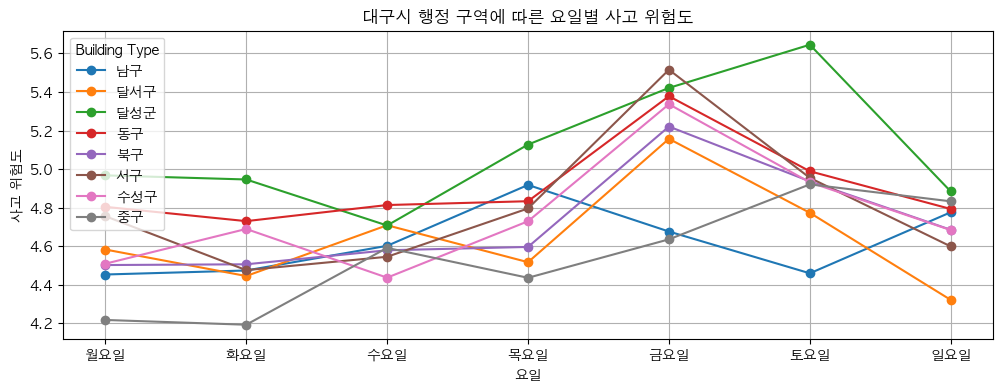

In [20]:
plt.figure(figsize=(12, 4))

for gu_name in weekday_gu_stats['구'].unique():
    subset = weekday_gu_stats[weekday_gu_stats['구'] == gu_name]
    plt.plot(subset['요일'], subset['ECLO'], marker='o', label=gu_name)

plt.xticks(ticks=range(7), labels=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일'])
plt.xlabel('요일')
plt.ylabel('사고 위험도')
plt.title('대구시 행정 구역에 따른 요일별 사고 위험도')
plt.legend(title='Building Type')
plt.grid(True)
plt.show()

💁‍♀️ **Report**
- **달성군** 에서 사고 위험도가 가장 높게 나타남
- **금요일** 에 사고 위험도가 가장 높게 나타남
- 나머지 요일에선 비슷한 패턴의 위험도가 보이나, 특징적인 구가 존재
  - *남구* : 전반적으로 낮은 위험도, 다만 목요일에 사고 위험도가 가장 높게 나타남
  - *중구* : 가장 위험도가 낮아보이나, 주말 (토,일) 에 비교적 높은 사고 위험도가 나타남 

### **분석 2 : 기상상태에 따른 사고 위험도**
기상상태가 ECLO에 얼마나 영향을 미칠까?

In [ ]:
import seaborn as sns

In [ ]:
# 기상상태별 사고 빈도수
weather_stats = train_df.groupby(['기상상태'])['기상상태'].count()
weather_stats_df = weather_stats.to_frame()
weather_df = weather_stats_df.rename(columns={'기상상태':'사고수'})
weather_df

sns.barplot(x='기상상태', y='사고수', data=weather_df)
plt.show()

In [ ]:
# 기상상태에 따른 사고위험도 분포 => 히스토그램 (맑음/비/흐림) => 점수화 시키기 (수치화) => 회귀 모델 ECLO 예측 
sns.scatterplot(x='기상상태', y='ECLO', data=train_df)
plt.show()

💁‍♀️ **Report**
- **사고빈도수 많은 순서** : 맑음-비-흐림-기타-눈/비
- **사고위험도**
  - *맑음* : 사고위험도의 범위가 가장 넓으며, 가장 높은 사고위험도의 사고가 발생
  - *비* : 두번째로 사고위험도의 범위가 넓으나, 높은 사고위험도 (40~60) 에서의 사고발생은 소수 

### **분석 3 : 사고유형 따른 사고 위험도**
사고유형에 따라 ECLO가 높아지는가?

In [ ]:
sns.scatterplot(x='사고유형', y='ECLO', data=train_df)
plt.show()